### Topic Modeling with WordEmbedding


In this notebook, I will try to train topic modeling using word embedding on tweets and see what it leads to.

I will be using this tutorial as a reference: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

##### 1. The Data

In [1]:
import pandas as pd

In [2]:
news_data = pd.read_csv("data/congo-news.csv", index_col=0, parse_dates=['posted_at'])

In [3]:
news_data.head()

,title,content,summary,posted_at,website_origin
0,RDC : Les Jeux de la Francophonie ont stimulé ...,« En plus des résultats plus que satisfaisants...,NaN,NaT,https://www.7sur7.cd
1,Ituri : 3 civils tués par des miliciens CODECO...,Trois (3) civils ont été tués et 2 autres griè...,NaN,NaT,https://www.7sur7.cd
2,RDC : Le succès des Jeux de la Francophonie pr...,Cette Organisation de la société civile félici...,NaN,NaT,https://www.7sur7.cd
3,Beni : 2 ADF de nationalité ougandaise tués pa...,Selon le porte-parole du secteur opérationnel ...,NaN,NaT,https://www.7sur7.cd
4,Kinshasa : 5 morts dans l’incendie provoqué pa...,C'est ce qu'a affirmé le vice-gouverneur de la...,NaN,NaT,https://www.7sur7.cd


In [4]:
news_data = news_data.sort_values(by='posted_at', ascending=False)

In [5]:
news_data.head()

,title,content,summary,posted_at,website_origin
623,"Silence, le Président s’auto-évalue !",De l’ancien premier ministre socialiste frança...,NaN,2023-12-07,https://forumdesas.net
420,Le Secrétaire exécutif du Copirep exhorte le p...,Le Secrétaire exécutif du Comité de pilotage d...,NaN,2023-12-06,https://forumdesas.net
501,Mgr Fulgence Muteba « fustige le fossé criant ...,"Mgr Fulgence Muteba, archevêque métropolitain ...",NaN,2023-12-06,https://forumdesas.net
399,« Seul Muzito a élevé à 2000 USD le salaire de...,"Dans une interview accordée à la RTGA, samedi ...",NaN,2023-12-06,https://forumdesas.net
522,Magistrature : voici les 2.500 nouveaux magist...,Au terme des ordonnances lues hier dimanche 11...,NaN,2023-12-06,https://forumdesas.net


### Data Cleaning

With the clustering I realized that the data has many empty contents and  some articles have duplicate contents. I will remove the empty contents and the duplicate contents.


In [10]:
news_data = news_data.loc[news_data.content.str.strip().str.len() > 0, :]

Pandas find duplicates values in a column

In [14]:
# drop duplicates content
news_data = news_data.drop_duplicates(subset=['content'])

In [15]:
news_data.shape

(66062, 5)

### Encoding.

To learn the vector representation of our tweets we will be using the BERT model, but instead of using the main bert model, we will be using the bert model that was trained on a corpus of french tweets since most of our target tweets are from French. `Yanzhu/bertweetfr-base`. is the model we will be using.

In [16]:
from sentence_transformers import SentenceTransformer

In [17]:
from pathlib import Path

In [18]:
trained_model_path = Path.cwd().joinpath("trained_models", "congo-news-masked-language-model")

In [19]:
model = SentenceTransformer(trained_model_path)

No sentence-transformers model found with name /Users/esp.py/Projects/Personal/balobi_nini/trained_models/congo-news-masked-language-model. Creating a new one with MEAN pooling.
Some weights of CamembertModel were not initialized from the model checkpoint at /Users/esp.py/Projects/Personal/balobi_nini/trained_models/congo-news-masked-language-model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
news_data.loc[news_data.posted_at.notna()].groupby('posted_at').count().sort_values('title', ascending=False).sort_index(ascending=False).head(10)

,title,content,summary,website_origin
posted_at,,,,
2023-12-07 00:00:00,1,1,0,1
2023-12-06 00:00:00,11,11,0,11
2023-12-05 00:00:00,1,1,0,1
2023-11-07 00:00:00,1,1,0,1
2023-11-05 00:00:00,20,20,0,20
2023-10-07 00:00:00,11,11,0,11
2023-09-06 00:00:00,2,2,0,2
2023-08-08 15:19:36,1,1,0,1
2023-08-08 12:13:12,1,1,0,1


Use the model to learn embedding for the documents

### simulate today news



simulate today news by samplign only 1000 news from the whole dataset

In [20]:
today_news = news_data.content.sample(10000)

In [21]:
today_news_embeddings = model.encode(today_news.values, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [22]:
today_news_embeddings.shape

(10000, 768)

with the encoding done, we can move to the next step which is the clustering.

Before applying the clustering, we will use the umap-learn algorithm.

In [23]:
import numpy as np

In [24]:
np.__version__

'1.24.0'

In [25]:
import umap

/Users/esp.py/Projects/Personal/balobi_nini/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/esp.py/Projects/Personal/balobi_nini/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/esp.py/Projects/Personal/balobi_n

We used umap dimensionality reduction algorithm to reduce the dimension of our data to 5 this will help us to visualize the data.

In [75]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(today_news_embeddings)

In [76]:
umap_embeddings.shape

(10000, 5)

In [77]:
from hdbscan import HDBSCAN

In [78]:
cluster = HDBSCAN(min_cluster_size=10,
                  metric='euclidean',                      
                  cluster_selection_method='eom').fit(umap_embeddings)

In [79]:
cluster.labels_.shape

(10000,)

In [80]:
### find unique elments in the cluster labels
np.unique(cluster.labels_)

array([0, 1])

In [33]:
# values counts of each element in the numpy array of clusters

np.unique(cluster.labels_, return_counts=True)


(array([0, 1]), array([ 314, 9686]))

In [34]:
# get the index of label 1 in the cluster

np.where(cluster.labels_ == 0)

(array([  74,  107,  111,  194,  207,  292,  311,  330,  362,  363,  368,
         394,  411,  456,  498,  500,  503,  505,  528,  565,  645,  718,
         723,  727,  828,  840,  878,  930,  970, 1035, 1053, 1186, 1206,
        1215, 1302, 1306, 1312, 1337, 1348, 1421, 1460, 1468, 1476, 1519,
        1533, 1539, 1584, 1598, 1637, 1674, 1693, 1767, 1815, 1831, 1879,
        1882, 1886, 1894, 1896, 1915, 1936, 1948, 1954, 2001, 2039, 2041,
        2045, 2118, 2172, 2234, 2328, 2381, 2392, 2442, 2485, 2513, 2515,
        2525, 2614, 2685, 2686, 2689, 2721, 2750, 2784, 2808, 2813, 2820,
        2858, 2879, 2902, 2930, 2937, 2938, 3099, 3122, 3215, 3218, 3220,
        3249, 3251, 3273, 3278, 3289, 3359, 3360, 3370, 3388, 3439, 3479,
        3518, 3538, 3572, 3588, 3690, 3748, 3759, 3772, 3777, 3810, 3817,
        3846, 4018, 4038, 4082, 4113, 4116, 4142, 4246, 4247, 4269, 4270,
        4287, 4352, 4372, 4420, 4473, 4508, 4520, 4527, 4578, 4658, 4660,
        4709, 4739, 4749, 4764, 4796, 

In [35]:
today_news = today_news.reset_index(drop=True)

In [37]:
today_news.loc[np.where(cluster.labels_ == 1)[0]]

0       \nLe joueur du TP Mazembe, Trésor Mputu n'a pa...
1       Le coordonnateur du Comité Stratégique du Fron...
2       La classe politique congolaise rend ses dernie...
3       Par CAS-INFOSes 17 passagers et les membres de...
4       Boutiques, magasins, banques et autres édifice...
                              ...                        
9995    L’artiste musicien, percussionniste et auteur-...
9996    Le président intérimaire de l'Union pour la Dé...
9997    Le caucus des députés nationaux de la province...
9998    Dans une déclaration lue devant la presse ce j...
9999    Une année après la promulgation de la loi d’am...
Name: content, Length: 9686, dtype: object

from what I can see, there is a need for more cleaning.

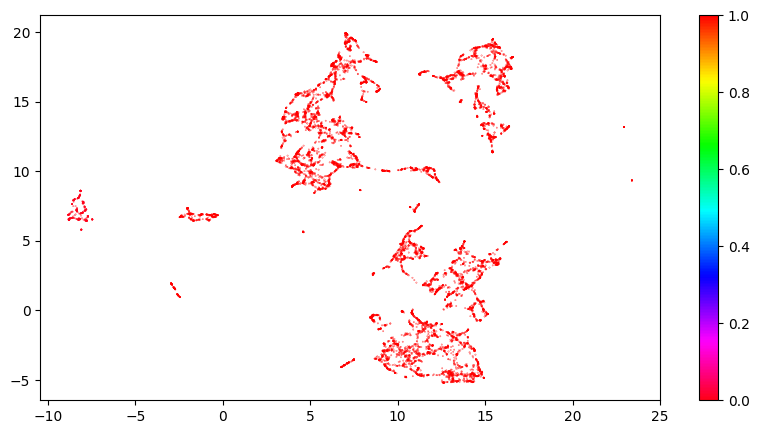

In [38]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
result.la

This is the represenntation of our cluster if we use only two dimension to represent the data.

In [56]:
today_news = today_news.drop(["Topic", "Doc_ID"], axis='rows')

In [57]:
docs_df = pd.DataFrame(today_news)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'content': ' '.join})

In [60]:
docs_per_topic

,Topic,content
0,0,Le Football Club Renaissance du Congo a offici...
1,1,"\nLe joueur du TP Mazembe, Trésor Mputu n'a pa..."


In [67]:
from nltk.corpus import stopwords

In [68]:
french_stopwords = stopwords.words('french')

In [69]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=french_stopwords).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.content.values, m=today_news.shape[0])

In [70]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .content
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "content": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
1,1,9686
0,0,314


In [71]:
top_n_words

{0: [('club', 0.014004717649397131),
  ('match', 0.013115080322956515),
  ('mazembe', 0.00970076053257946),
  ('léopards', 0.008844241468535588),
  ('football', 0.0088307068768695),
  ('score', 0.008029169672857788),
  ('championnat', 0.007512125214685487),
  ('finale', 0.007370898379014657),
  ('coupe', 0.0072912027967079055),
  ('ligue', 0.007053199823862238),
  ('stade', 0.006983284999683813),
  ('buts', 0.006262496574786641),
  ('joueurs', 0.006140013347303906),
  ('points', 0.006071771215072964),
  ('équipe', 0.005880894657694624),
  ('dcmp', 0.005435970495403887),
  ('ibenge', 0.0052629652753464345),
  ('caf', 0.004958643661378382),
  ('tp mazembe', 0.004939865704107734),
  ('tp', 0.004849775583706124)],
 1: [('province', 0.000968526590988659),
  ('général', 0.0009676225210576064),
  ('etat', 0.0009667006698885949),
  ('selon', 0.0009650480002209461),
  ('élections', 0.0009623017711960226),
  ('cas', 0.0009617875074460151),
  ('démocratique', 0.0009596002710945023),
  ('kabila', 

We can see that we don't get the results we were expecting at the first try we can do better.

We need to improve our cleaning and understand the algorithm we are using better.

-  Giving up on this, let me finsish the other project on machine translation and come back to this later.

When I come back the main work will be to finetune distilbert on the tweets embedding to learn contextualized embedding related to my data.

### Results on First Approach

As we can see, the first approach seems to not be working, we need to find a best algorithm that will works better, The first one was only able to generalize two topics sports and plotics, We would like to keep on improving the model and use a more general hiereachical approach that will classify the news.

In [91]:
today_news_embeddings.shape

(10000, 768)

#### MiniBatch KMeans Clustering

In this section we will try the mini batch kmean clustering algorithm.

In [160]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [95]:
def print_silhouette_values(data, k_means):
    sample_silhouette_values = silhouette_samples(data, k_means.labels_)
    print("the silhouette values are :")
    silhouette_values = []
    for i in range(len(k_means.labels_)):
        ith_cluster_silhouette_values = sample_silhouette_values[k_means.labels_ == i]
        silhouette_values.append((i, ith_cluster_silhouette_values.mean()))
        silhouette_values.append(
            (
                i,
                ith_cluster_silhouette_values.shape[0],
                ith_cluster_silhouette_values.mean(),
                ith_cluster_silhouette_values.min(),
                ith_cluster_silhouette_values.max(),
            )
        )
    silhouette_values = sorted(silhouette_values, key=lambda x: x[2], reverse=True)

    for s in silhouette_values:
        print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )

In [161]:
def mini_batch_k_means_clusters(data, number_clusters, should_print_silhouette_values=True):
    """
    generate clusters using mini batch k-means algorithm

    Args:
        data (_type_): the dataset to be clustered
        number_clusters (_type_): the number of clusters to generate
        mini_batch_size (_type_): the size of the mini batch
        print_silhouette_values (bool, optional): _description_. Defaults to True.
    """
    k_means = KMeans(n_clusters=number_clusters, random_state=42).fit(data)
    print(f"for n cluster ={number_clusters}")
    print(f"silhouette score is {silhouette_score(data, k_means.labels_)}")
    print(f"the inertia is {k_means.inertia_}")

    if should_print_silhouette_values:
        print_silhouette_values(data, k_means=k_means)
    return k_means


### Dimensions Reduction

Before applying clustering we need to reduce the dimension of our dataset because, researchers have proved that most of similarity measures does not work in higher dimension spaces. https://stats.stackexchange.com/a/99191/154672

Let us use the PCA implementation from sklearn to reduce the dimension of our dataset to 50, let us hope that with that dimension we will not use to much information.

In [102]:
from sklearn.decomposition import PCA

In [109]:
pca  = PCA(n_components=20)
today_news_embeddings_transformed = pca.fit_transform(today_news_embeddings)

In [110]:
(pca.explained_variance_ratio_ * 100).round(2)

array([31.89,  9.11,  7.11,  4.61,  3.72,  2.92,  2.73,  2.27,  2.16,
        1.64,  1.61,  1.44,  1.24,  1.05,  0.96,  0.93,  0.86,  0.79,
        0.77,  0.76], dtype=float32)

In [111]:
today_news_embeddings_transformed.shape

(10000, 20)

Once we have reduced the dimension of our dataset we can apply the K mean algorithm to the created dataset to learn the embedding.

In [166]:
clusters = mini_batch_k_means_clusters(today_news_embeddings_transformed, number_clusters=5, should_print_silhouette_values=False)

/Users/esp.py/Projects/Personal/balobi_nini/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for n cluster =5
silhouette score is 0.11919175833463669
the inertia is 71591.4453125


Before diving into the cluster analysis, we need to visualize how  our prediction are done.

In [210]:
today_news_df = pd.DataFrame({"content": today_news, "Topic": clusters.labels_})

In [211]:
today_news_df.head()

,content,Topic
0,"\nLe joueur du TP Mazembe, Trésor Mputu n'a pa...",4
1,Le coordonnateur du Comité Stratégique du Fron...,3
2,La classe politique congolaise rend ses dernie...,4
3,Par CAS-INFOSes 17 passagers et les membres de...,2
4,"Boutiques, magasins, banques et autres édifice...",4


In [171]:
today_news_df.cluster.value_counts()

cluster
0    2606
1    2089
4    2087
3    1744
2    1474
Name: count, dtype: int64

In [212]:
today_news_df.query('Topic ==1')

,content,Topic
8,Hier Jeudi 6 août 2015 à la Prison Centrale de...,1
10,"La Société Civile, quant à elle, a positionné ...",1
18,Le dialogue politique est loin de faire l’unan...,1
21,Par siméon IsakoAnnoncé la semaine dernière pa...,1
30,"Le parti au pouvoir en Tanzanie, Chama Cha Map...",1
...,...,...
9988,"Implanté à la 16ème rue, en plein quartier ind...",1
9989,Partant de leurs actions ou réalisations à tra...,1
9993,Le sénat et l’assemblée nationale du Rwanda vi...,1
9995,"L’artiste musicien, percussionniste et auteur-...",1


In [157]:
from scipy.spatial import distance

In [187]:
def compute_cosine_distance(a, b):
    """given two vectors a and b, compute the cosine distance between them

    Args:
        a (_type_): 
        b (_type_): _description_
    """
    return distance.euclidean(a, b)


In [202]:
compute_cosine_distance(today_news_embeddings[12],  today_news_embeddings[3])

# The closer to zero the ecludin distance is, the more similar the two vectors are.

3.8475351333618164

In [184]:
from pprint import pprint

In [185]:
pprint(today_news_df.loc[12, 'content'])

('Dans une déclaration faite le dimanche 20 novembre 2022 et dont une copie '
 'est parvenue à 7SUR7.CD, cette formation politique estime que la levée de '
 "cette mesure va à coup sûr permettre à l'armée congolaise de faire face "
 'notamment à l\'agression rwandaise sous couvert du M23. \xa0"La FRPI/C '
 "appelle l'ONU à lever l'embargo voilé à travers son fameux régime de "
 "notification pour permettre à l'Etat congolais de doter son armée des moyens "
 "de sa défense. La FRPI dénonce la complaisance et l'hypocrisie de la "
 "communauté internationale, qui dans sa politique d'autruche légendaire, joue "
 "un double jeu en faveur de l'ennemi. D'un côté, elle s'avoue ne pas être "
 'capable de faire quelque chose devant le M23 sous prétexte que ses armes '
 'sont sophistiquées mais ne dénonce pas les pays derrière ces armements. Dans '
 "l'entretemps, elle exclut à une armée nationale de se procurer les moyens "
 'nécessaires pour sa protection par un embargo injustifié", peut-on lir

In [186]:
pprint(today_news_df.loc[3, 'content'])

('Par CAS-INFOSes 17 passagers et les membres de l’équipage resteront à bord '
 'pendant au moins deux semaines. Le bateau Lengwe en provenance de la '
 'Tanzanie n’a pas été autorisé à accoster et décharger ses marchandises à '
 'Kalemie.Les autorités locales qui ont décidé de placer ce navire de la SNCC '
 'en quarantaine estiment qu’il a violé la mesure de fermeture des frontières '
 'décrétée par le chef de l’État.Selon Radio Okapi, une équipe de contrôle '
 'médical a été dépêchée à bord de ce navire pour s’enquérir de l’état de '
 'santé des passagers.Il faut rappeler que la RDC qui fait face depuis un mois '
 'à l’épidémie de coronavirus a décidé de fermer les frontières avec ses '
 'voisins et d’isoler la ville de Kinshasa, considérée comme épicentre de la '
 'maladie. Dans la capitale, les autorités ont également décidé de confiner la '
 'commune de la Gombe, qui regorge plus de cas que les autres municipalités.')


Seems like my embedding are not working properly. I will try to use the embedding from the bert model.

 Let us analyze the cluster by plotting the most common world in a cluster.

In [213]:
docs_per_topic = today_news_df.groupby(['Topic'], as_index = False).agg({'content': ' '.join})

In [215]:
docs_per_topic

,Topic,content
0,0,"Le gouverneur Alex Kande a posé, le 12 août, l..."
1,1,Hier Jeudi 6 août 2015 à la Prison Centrale de...
2,2,Par CAS-INFOSes 17 passagers et les membres de...
3,3,Le coordonnateur du Comité Stratégique du Fron...
4,4,"\nLe joueur du TP Mazembe, Trésor Mputu n'a pa..."


In [216]:
  
tf_idf, count = c_tf_idf(docs_per_topic.content.values, m=today_news.shape[0])

In [218]:
count

CountVectorizer(ngram_range=(1, 2),
                stop_words=['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de',
                            'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils',
                            'je', 'la', 'le', 'les', 'leur', 'lui', 'ma',
                            'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne',
                            'nos', ...])

In [219]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(today_news_df); 

topic_sizes.head(10)

,Topic,Size
0,0,2606
1,1,2089
4,4,2087
3,3,1744
2,2,1474


In [220]:
top_n_words

{0: [('dialogue', 0.0014233313591061776),
  ('électoral', 0.0013889365670278204),
  ('développement', 0.001381423604978657),
  ('élections', 0.0013783753805731826),
  ('loi', 0.0012924335864543876),
  ('constitution', 0.0012780850975193671),
  ('processus', 0.0012443373908264676),
  ('ceni', 0.0012202990177083925),
  ('etat', 0.0012034700562277303),
  ('politiques', 0.0011970473258575462),
  ('cadre', 0.0011795051010292897),
  ('projet', 0.0011768601668368569),
  ('mise', 0.0011566957105367632),
  ('droits', 0.0011553828856384427),
  ('national', 0.0011271755284478003),
  ('ainsi', 0.0011262262308341315),
  ('2016', 0.0011148670472702668),
  ('organisation', 0.0011125619633522259),
  ('notamment', 0.0011114767040782516),
  ('afin', 0.001109149510335859)],
 1: [('sans', 0.0013294185216148598),
  ('bien', 0.0013056298176800615),
  ('si', 0.0012754882559831543),
  ('comme', 0.0012575032235877354),
  ('tout', 0.001190669217825575),
  ('non', 0.0011402568430580854),
  ('où', 0.0011164184661

We are progressing and learning a lot of values form the clustering. Few things to do, investigate the quality of the embedding we are using, and peform more pre processing.

In [230]:
news_data.website_origin.value_counts()

website_origin
https://www.7sur7.cd      51540
https://cas-info.ca       12213
https://scooprdc.net        941
https://actu30.cd           916
https://lepotentiel.cd      275
https://forumdesas.net      177
Name: count, dtype: int64

In [228]:
today_news.tail(20)

9980    Le PG Firmin Mvonde a, par ailleurs, décidé de...
9981    Les armateurs de la République Démocratique du...
9982    Le chef de l'État Félix Antoine Tshisekedi Tsh...
9983    D'après certains travailleurs de l'ex Onatra (...
9984    Un décryptage de la révolution numérique s’imp...
9985    Mercredi 22 mai dernier, un groupe de députés ...
9986    .À la presse, le chef de la délégation a décla...
9987    La nuit de dimanche à lundi a été calme à Beni...
9988    Implanté à la 16ème rue, en plein quartier ind...
9989    Partant de leurs actions ou réalisations à tra...
9990    Les ex-M23 constituent l'un des facteurs qui e...
9991    Le plus vieux parti de la RD-Congo en activité...
9992    Par CAS-INFOEn sa qualité de président en exer...
9993    Le sénat et l’assemblée nationale du Rwanda vi...
9994    Soixante-quatre cas de diarrhées sont constaté...
9995    L’artiste musicien, percussionniste et auteur-...
9996    Le président intérimaire de l'Union pour la Dé...
9997    Le cau

### Testing if the embedding are working.

In [231]:
article_one = [
    """
    Les Léopards sont arrivés ce lundi 11 septembre en fin d’après-midi à Johannesburg en Afrique du Sud sans Arthur Masuaku, Vital Nsimba, Théo Bongonda et William Balikwisha qui ont regagné leurs clubs respectifs au lendemain de la victoire (2-0) de la RDC face au Soudan, le samedi 9 septembre au stade des Martyrs de la Pentecôte de Kinshasa.

L’affiche RDC-Afrique du Sud sera une rencontre passionnante entre deux nations africaines qui chercheront à se préparer pour leurs prochains défis. Ce match amical suscite beaucoup d’attentes de la part des supporters des deux équipes. Il s’agit d’une occasion pour les joueurs de montrer leur talent. Les supporters espèrent voir un match compétitif et spectaculaire, avec de belles actions et des buts. Les entraîneurs des deux équipes auront également l’occasion d’évaluer leurs joueurs et de tester différentes stratégies.

Les Léopards qui comptent de nombreux joueurs talentueux évoluant dans des clubs européens vont naturellement miser sur la force physique, la vitesse et la technique avec des joueurs clés tels que Cédric Bakambu et Chancel Mbemba. C’est une équipe qui a le moral haut après la victoire devant le Soudan. Theo Bongonda (8′) et Fiston Kalala Mayele (87′) ont inscrit les deux buts victorieux. Un soulagement pour le peuple congolais, qui n’avait pas eu le plaisir de voir son équipe y participer lors de la dernière édition ! Les Léopards finissent ainsi en tête de leur poule I avec 12 points. Du côté de l’Afrique du Sud, les talents sont également à jour dans cette équipe connue pour son jeu offensif et son style de jeu rapide. Après avoir frappé fort en juin face au Maroc (2-1), l’Afrique du Sud a concédé un match nul décevant (0-0) samedi face à la Namibie. Un résultat pour le moins mitigé puisque malgré une nette domination (71 vs 29 %) et de nombreuses occasions (6 tirs cadrés contre 1), les Bafana Bafana n’ont pu trouver la faille. Ils espèreront se rassurer en l’emportant devant la RDC, qui a de son côté assuré sa qualification pour la CAN devant le Soudan (2-0)."""
]

In [232]:
article_two = [
    """
    Une délégation, composée de joueurs et membres du staff technique de l’équipe nationale de football de la République démocratique du Congo, s’est envolée, ce lundi 11 septembre 2023, via à l’aéroport international de N’djili pour la ville de Johannesburg, en Afrique du Sud, où ils affronteront les Bafana Bafana ce mardi 12 septembre.

Cette rencontre amicale, qui entre dans le cadre de la trêve internationale, va se jouer au stade Orlando sous le coup de 16 heures locales.

Ce match sera une occasion, avait souligné le sélectionneur de la RDC, de donner du temps de jeu à d’autres joueurs de l’équipe nationale de la RDC.

À noter les Léopards de la RDC seront de nouveau sur la pelouse 48 heures après leur qualification pour la 34ème édition de la Coupe d’Afrique des Nations prévue au mois de janvier 2024 en Côte d’Ivoire.

Mechack Wabeno
    """
]

In [269]:
article_three = """
Après le carnage survenu dans la ville de Goma, le 30 août dernier, le barza intercommunautaire du Nord-Kivu appelle la population à ne plus participer aux manipulations de tout genre.

Dans une déclaration lue devant la presse, lundi 11 septembre, au sortir d’une réunion de sécurité élargie aux présidents et représentants des communautés autour du gouverneur intérimaire, le Barza a signifié que ce n’est plus le moment d’inciter la population aux actions qui aboutissent aux dérapages.

« Ce n’est plus le moment d’appeler la population à l’observance des villes mortes, car ces dernières se transforment en des dérapages conduisant à des pertes en vies humaines et des biens matériels des populations déjà meurtries », rapporte cette déclaration.

Ces représentants des communautés du Nord-Kivu rappellent que le gouvernement s’est déjà porté garant pour un enterrement digne des victimes du carnage et a promis d’accélérer le processus du retrait de la MONUSCO.

Entre-temps, des messages d’appel à une journée ville morte, ce mercredi, à Goma, lancés par les mouvements citoyens circulent déjà sur les réseaux sociaux.

Plus de 50 personnes ont perdu la vie dans les manifestations du 30 août de l’année en cours à Goma.

"""

In [250]:
article_one_embeddings = model.encode(article_one)
article_two_embeddings = model.encode(article_two)

In [270]:
article_three_embeddings = model.encode(article_three)

In [271]:
article_three_embeddings

array([ 1.25896439e-01,  3.13706338e-01,  1.64171055e-01,  5.93610168e-01,
        1.28246501e-01, -1.59435123e-01,  7.94281960e-02,  4.07503575e-01,
       -6.95991293e-02,  8.32009137e-01, -3.21829915e-01,  4.41460609e-02,
       -7.10797384e-02,  6.32890642e-01,  6.40203357e-01, -3.06100339e-01,
        5.95003545e-01, -2.21239775e-01,  3.00597519e-01,  6.53308723e-03,
        8.98121074e-02, -1.95849225e-01,  3.34434777e-01, -3.62295121e-01,
       -1.29972613e+00, -1.01091838e+00, -2.40245938e-01, -1.49136633e-01,
        2.18590647e-01, -2.91955769e-01,  3.30381244e-01,  3.07319522e-01,
        7.76172817e-01,  1.65125340e-01, -2.59996414e-01,  2.27667481e-01,
        5.51775157e-01,  1.27791852e-01,  3.93910795e-01, -8.81829739e-01,
       -4.93037933e-03,  1.13380782e-01, -7.51591250e-02,  4.20408361e-02,
       -1.74595058e-01,  6.35977924e-01,  2.13874951e-01,  1.58005878e-01,
        2.84139246e-01, -4.94659543e-02, -9.63094011e-02, -1.55158490e-01,
       -4.21614379e-01, -

In [273]:
from scipy.spatial.distance import cosine, euclidean

In [275]:
# compute cosine similarity between the two embeddings using scipy
# input: two embeddings
# output: cosine similarity
def cosine_similarity(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)

In [259]:
cosine_similarity(article_one_embeddings.ravel(), article_two_embeddings.ravel())

0.9861726760864258

The two articles are similar because of their  content is almost the same, they are both talking about football.

In [272]:
cosine_similarity(article_three_embeddings.ravel(), article_two_embeddings.ravel())

0.9749183058738708

In [277]:
cosine_similarity(np.array([0, 1]), np.array([-1, 0 ]))

0.0

Need to improve the quality of the word embeddings.

New Approaches to try:

 - https://colab.research.google.com/drive/1bfWUYEypULFk_4Tfff-Pb_n7-tSjEe9v?usp=sharing
 - https://github.com/ddangelov/Top2Vec
 